# __**BLOCK 2**__

# 3. Using the model and analyzing the most frequent words in a set of news obtained from a media organization.

### To get the set of news, the API news is going to be used. This API is available for Python and collects news depending on the media organization, date, language...
#### For more information related to this API see the below link:
#### https://newsapi.org/docs/get-started
##### Note: An internet connection is required to run the code

##### The code of this notebook was used to create the Dash interface part 2. Note that the analysis related to the most relevant words of each corpus, was not included in the Dash interface. See the "5_Dash_framework_part_2.ipynb" notebook for more information

### To use the API the below package should be installed.

In [ ]:
!pip install newsapi-python

In [1]:
from newsapi import NewsApiClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from datetime import date, timedelta

## 3.1 Training the model

In [2]:
#The data used to train the model
path_file= './data/dataset_news.csv'
file=pd.read_csv(path_file, sep=',')

In [3]:
#A function is created to normalize the text, removing punctuation symbols and double spaces. This cleaned data is 
#saved in a new column ('TEXT').
def normalize_text(text):
    text = text.lower()
    
    # remove punctuation that is not word-internal (e.g., hyphens, apostrophes)
    text = re.sub('\s\W',' ',text)
    text = re.sub('\W\s',' ',text)
    
    # make sure we didn't introduce any double spaces
    text = re.sub('\s+',' ',text)
    
    return text

file['TEXT'] = [normalize_text(text) for text in file['TITLE']]

In [4]:
#The text is going to be vectorized.  For more info see the below link:
#http://scikit-learn.org/stable/modules/feature_extraction.html
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(file['TEXT'])
encoder = LabelEncoder()
y = encoder.fit_transform(file['CATEGORY'])

In [5]:
### the Naive Bayes model e dividimos o data set co StrtifiedKfold polas razóns da explicación de arriba
### the data is splitted using the Strtified K fold.
kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
i=1
score_mean=[]

for train_index,test_index in kf.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #Naive Bayes model
    nb = MultinomialNB()
    classifier_model = nb.fit(X_train, y_train)
    score = nb.score(X_test, y_test)
    score_mean.append(score)
    print(score)
    i+=1
print('The mean of the whole predictions is:',sum(score_mean)/len(score_mean))

0.92528939706
0.926993821462
0.926188954383
0.926615060483
0.927370863122
0.927015766299
0.928294114862
0.928008333136
0.926895670084
0.926537086579
The mean of the whole predictions is: 0.926920906747


## 3.2 Getting the news

### With this API, it is possible to get news from different media sources. 
### For more information see the below link:
https://newsapi.org/docs/get-started

##### Note: An internet connection is required to run the code

In [6]:
# The api_key is the key from my account, which can be used to obtain the set of news.
newsapi = NewsApiClient(api_key='9fe0d6dd387c40bc8cb5fdec346f0bda')

In [7]:
today= str(date.today())
yesterday = str(date.today()-timedelta(1))

#For more information related to the newspi.get_everything, see te link https://newsapi.org/docs/endpoints/everything

all_articles = newsapi.get_everything(sources='australian-financial-review',
                                      domains='bbc.co.uk,techcrunch.com',
                                      from_param= yesterday,
                                      to= today,
                                      language='en',
                                      sort_by='relevancy',
                                      page=5)                    

In [8]:
#To see the available media sources
sources = newsapi.get_sources()
sources

{'sources': [{'category': 'general',
   'country': 'us',
   'description': 'Your trusted source for breaking news, analysis, exclusive interviews, headlines, and videos at ABCNews.com.',
   'id': 'abc-news',
   'language': 'en',
   'name': 'ABC News',
   'url': 'https://abcnews.go.com'},
  {'category': 'general',
   'country': 'au',
   'description': "Australia's most trusted source of local, national and world news. Comprehensive, independent, in-depth analysis, the latest business, sport, weather and more.",
   'id': 'abc-news-au',
   'language': 'en',
   'name': 'ABC News (AU)',
   'url': 'http://www.abc.net.au/news'},
  {'category': 'general',
   'country': 'no',
   'description': 'Norges ledende nettavis med alltid oppdaterte nyheter innenfor innenriks, utenriks, sport og kultur.',
   'id': 'aftenposten',
   'language': 'no',
   'name': 'Aftenposten',
   'url': 'https://www.aftenposten.no'},
  {'category': 'general',
   'country': 'us',
   'description': 'News, analysis from the M

## 3.3 Missing values in the data set obtained from the API news.

When the news are downloaded from the API, they contain
none values in the value of the ['content'] key. This none values will cause problems when the news are classified 
with our model

In [9]:
#we are going to select just the key 'content' which has text. When the news are downloaded from the API, they contain
#none values in the value of the ['content'] key. This none values will cause problemns when the news are classified 
#with our model
clean_text=[]
for text in all_articles['articles']:
    #if the value of the ['content']key is a string, it is putted in a new list (clean_text).
    if type(text['content'])==str:
        clean_text.append(text)  
clean_text


[{'author': 'https://www.facebook.com/bbcnews',
  'content': 'Image copyright PA Image caption Fiona Onasanya denies perverting the course of justice A Labour MP accused of plotting to avoid a speeding prosecution said she was overwhelmed by "thousands" of emails when she first started her job. Peterborough MP Fiona Ona… [+1816 chars]',
  'description': 'A MP accused of trying to avoid a speeding prosecution says she was overwhelmed on becoming a MP.',
  'publishedAt': '2018-11-19T15:01:21Z',
  'source': {'id': 'bbc-news', 'name': 'BBC News'},
  'title': "MP Fiona Onasanya trial: MP 'overwhelmed by emails', court hears",
  'url': 'https://www.bbc.co.uk/news/uk-england-cambridgeshire-46263183',
  'urlToImage': 'https://ichef.bbci.co.uk/news/1024/branded_news/14C35/production/_102954058_hi048655432.jpg'},
 {'author': None,
  'content': "Media playback is not supported on this device Gale's dramatic drop-goal sends Castleford into Grand Final Super League will introduce golden point extra

## 3.4 Plotting the classification of the news performed by the model

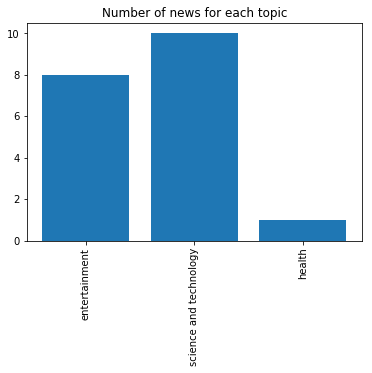

In [10]:
from sklearn import preprocessing
from collections import Counter

le = preprocessing.LabelEncoder()
le.fit(["business", "science and technology", "entertainment", "health"])

x_axis=[]

corpus_business=''
corpus_sciencetechnology=''
corpus_entertainment=''
corpus_health=''

#The classification of the news is performed. Thus, each news is placed in its proper corpus.
#In case there are News with a None in their content, the code will not run.
for i in range(len(clean_text)):
    prediction = nb.predict(vectorizer.transform([clean_text[i]['content']]))
    x_axis.append(list(le.inverse_transform(prediction)))
    #Each news is placed in its corpus.
    if list(le.inverse_transform(prediction)) == ['business']:
        corpus_business= corpus_business + '' + clean_text[i]['content']
    if list(le.inverse_transform(prediction)) == ['science and technology']:
        corpus_sciencetechnology= corpus_sciencetechnology + '' + clean_text[i]['content']
    if list(le.inverse_transform(prediction)) == ['entertainment']:
        corpus_entertainment= corpus_entertainment + '' + clean_text[i]['content']
    if list(le.inverse_transform(prediction)) == ['health']:
        corpus_health= corpus_health + '' + clean_text[i]['content']

corpus=[corpus_business,corpus_sciencetechnology,corpus_entertainment,corpus_health]

#The results will be putted just in one list. Without lists in the middle.
x_axis_list=[]
for i in range(len(x_axis)):
    x_axis_list.append(x_axis[i][0])
#The number of times that each element appears in the list is calculated.
x=Counter(x_axis_list)

#A bar_graph is plotted in order to see the number of news of each topic.
labels, values = zip(*Counter(x_axis_list).items())

indexes = np.arange(len(labels))

plt.bar(indexes, values)
plt.xticks(indexes , labels, rotation= 'vertical')
plt.title('Number of news for each topic')
plt.show()


## 3.3 Calculating the most relevant words of each class (business, entertainment, science/technology and health)

## 3.3.1 tf (*term frequency*)

[**tf**](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Term_frequency_2) es el peso que indica la frecuencia de un término, es decir, el número de veces que una determinada palabra aparece en un documento. 

La aproximación más sencilla consiste consiste en asignar como peso para el término $t$ en el documento $d$ del corpus $D$ (denotado como $\mbox{tf}_{t,d}$) el número de ocurrencias de $t$ en $d$. Es recomendable normalizar esta frecuencia, diviendo el número de ocurrencias entre el número total de palabras de un documento, para no penalizar los documentos breves: $\mathrm{tf}(t,d) = \frac{\mathrm{f}(t, d)}{\max\{\mathrm{f}(w, d):w \in d\}}$

Vamos a calcularlo.

In [20]:
tf={}
i=-1
for text in corpus:
    sentence=text.split()
    for word in sentence:
        tf[word]=[0]*len(corpus)

for text in corpus:
    sentence=text.split()
    i= i+1
    for word in sentence:
        tf[word][i]=sentence.count(word)/len(sentence)

In [12]:
corpus

['',
 "Media playback is not supported on this device Gale's dramatic drop-goal sends Castleford into Grand Final Super League will introduce golden point extra-time to regular-season competition from 2019. A statement issued on behalf of the 12 Super League clubs c… [+3175 chars]Kenyan President Uhuru Kenyatta has launched the countrys first-ever coast guard to protect and monitor its territorial waters. It is expected to cost $10m (£7.8m) a year. The new coast guard will aim to prevent smuggling, drug trafficking and illegal fishing… [+618 chars]Image copyright Getty Images Image caption Vision Direct says anyone who entered personal details into its site over a six day period could have been exposed Vision Direct is warning customers that a hack attack has exposed their personal data including payme… [+3051 chars]BuzzFeed News is giving readers a new way to support its journalism by paying a monthly or yearly fee. BuzzFeed might not seem like the most obvious publication to ask read

## 3.3.2 idf (*inverse document frequency*)

Trabajar unicamente con las frecuencias de los términos conlleva un problema: todos los términos presentes en la colección se consideran igualmente relevantes a la hora de discriminar la relevancia de los documentos, atendiendo a sus frecuencias. Y resulta que esto no es verdad. 

Imaginemos un corpus en el que la frecuencia total de dos términos concretos, *este* y *fonema*, es similar en términos absolutos. La distribución de estos términos a lo largo de la coleccion es seguramente muy diferente. El primero aparece con una distribución uniforme a lo largo del corpus, su capacidad discriminativa es baja y debería penalizarse a la hora de asignar relevancia (como el resto de *stopwords*). El segundo, por el contrario, se concentra principalmente en documentos que hablan de fonología, su capacidad discriminativa es alta y debería ser premiado.

Existen mecanismos correctores para incorporar estas penalizaciones y premios en nuestros pesos. Los más habituales pasan por recurrir a la frecuencia de documento $\mbox{df}_t$, definida como el número de documentos de la colección $D$ que contienen el término $t$: $\mbox{df}_t = {|\{d \in D: t \in d\}|}$.

Más concretamente, se calcula la frecuencia inversa de documento, o [**idf**](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Inverse_document_frequency_2) (*inverse document frequency*), definida como: $\mbox{idf}_t = \log {|D|\over \mbox{df}_t}$, donde $|D|$ indica el número total de documentos de nuestra colección. De este modo, el **idf** de un término específico pero muy discriminativo será alto, mientras que el de un término muy frecuente a lo largo de la coleccion será bajo.

##### Calculando df

In [13]:
import operator

df={}

for word in tf:
    df[word]=0
    for text in corpus:
        if word in text:
            df[word]+=1

#Ordenamos os valores de df polo value e quedamosns cos 20 primeriso
m=sorted(df.items(),key=operator.itemgetter(1),reverse=True)
m[:10]

[('is', 3),
 ('on', 3),
 ('to', 3),
 ('A', 3),
 ('of', 3),
 ('the', 3),
 ('has', 3),
 ('and', 3),
 ('a', 3),
 ('copyright', 3)]

Los valores de **df** son números enteros: el número de documentos del corpus que contienen cada uno de los términos.

##### Calculando idf

In [14]:
import math

idf={}
for word in df:
    idf[word]= math.log(len(corpus)/df[word])

## 3.3.3 tf.idf

[**td.idf**](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) (*term frequency - inverse document frequency*) es una medida numérica que expresa la relevancia de una palabra de un documento con respecto a una colección de documentos. Es uno de los esquemas de pesado más comunes en las tareas relacionadas con la recuperación de información y la minería de texto.

El objetivo de esta métrica es representar los documentos de texto como vectores, ignorando el orden concreto de las palabras pero manteniendo la información relativa a las frecuencias de aparición. 

El valor de tf-idf de una palabra:

- es mayor cuanto más frecuente sea esta palabra dentro de un documento concreto, pero;
- es mayor cuando menos común sea la palabra en otros documentos de la colección.

Estas dos características premian a los términos que son muy frecuentes en determinados documentos concretos pero poco comunes en general: estos términos pueden considerarse buenos descriptores de un conjunto de documentos. Y a la vez, penalizan aquellos términos que aparecen con mucha frecuencia a lo largo de toda la colección, como las *stopwords*.


#### Calculando **tf.idf**

**tf.idf** se calcula como el producto de dos términos: $\mathrm{tf.idf}(t, d, D) = \mathrm{tf}(t, d) \times \mathrm{idf}(t, D)$

- la frecuencia de un término (tf): el número de veces que una determinada palabra aparece en un documento. 

- la frecuencia inversa de documento (idf): el logaritmo del número total de documentos en el corpus dividido entre el número de documentos en los que el término aparece.

Ya hemos calculado previamente esos valores. Bastará con realizar los productos.

In [15]:
#Calculamos o tfidf
tfidf = {}

for word in tf:
    tfidf[word]=[]
    for value in tf[word]:
        tfidf[word].append(value*idf[word])

In [16]:
#The first corpus to be sorted are the words from the business
#The words from the business corpus are sorted by its value (tfidf).      
tfidf_business=sorted(tfidf.items(),key= lambda x : x[1][0],reverse=True)
#The second corpus to be sorted are the words from the science/technology corpus.
#The words from the science/technology corpus are sorted by its value (tfidf)      
tfidf_sciencetechnology=sorted(tfidf.items(),key= lambda x : x[1][1],reverse=True)
#The third corpus to be sorted are the words from the entertainment corpus
#The words from the entertainment corpus are sorted by its value (tfidf)     
tfidf_entertainment=sorted(tfidf.items(),key= lambda x : x[1][2],reverse=True)
#The fourth corpus to be sorted are the words from the health corpus.
#The words from the health corpus are sorted by its value (tfidf)      
tfidf_health =sorted(tfidf.items(),key= lambda x : x[1][3],reverse=True)

## 3.3.4 Representing the most important word of each corpus in a table

### Explanation of the data presented in the following tables.

The higher of the **tfidf** value in a specific corpus, the more importance of the word in that corpus.<br>
Note that a word is relevant in a corpus, when the word is repeated a lot of times in the corpus itself, and it is not present in other corpus.
Therefore, the different tables show the most important words for the business, entertainment, science/technology and
health corpus. Bear in mind that these words have a high value just in one of the corpus, and for the rest of them, the value is low or even 0.

In [19]:
#The top 10 most important words of the business corpus are represented in a table.
n=10
y_words_b=[tfidf_business[y][0] for y in range(n)]
y_business=[tfidf_business[y][1][0] for y in range(n) ]
y_business_sciencetechnolgy=[tfidf_business[y][1][1] for y in range(n) ]
y_business_entertainment=[tfidf_business[y][1][2] for y in range(n) ]
y_business_health=[tfidf_business[y][1][3] for y in range(n) ]

print('\033[1mThe most important words of the business corpus')

pd.DataFrame({'0_Words':y_words_b,'1_Business':y_business, '2_science&technology':y_business_sciencetechnolgy,
             '3_entertainment':y_business_entertainment, '4_health':y_business_health})

The most important words of the business corpus


,0_Words,1_Business,2_science&technology,3_entertainment,4_health
0,Media,0.0,0.001572,0.000000,0.0
1,playback,0.0,0.003144,0.000000,0.0
2,is,0.0,0.004566,0.003116,0.0
3,not,0.0,0.006287,0.000000,0.0
4,supported,0.0,0.003144,0.000000,0.0
5,on,0.0,0.002609,0.001039,0.0
6,this,0.0,0.001572,0.002502,0.0
7,device,0.0,0.003144,0.000000,0.0
8,Gale's,0.0,0.003144,0.000000,0.0
9,dramatic,0.0,0.003144,0.000000,0.0


In [21]:
#The top 10 most important words from the science/technolgy corpus are showed in the below table.

y_words_sc=[tfidf_sciencetechnology[y][0] for y in range(n)]
y_sciencetechnolgy_business=[tfidf_sciencetechnology[y][1][0] for y in range(n) ]
y_sciencetechnolgy=[tfidf_sciencetechnology[y][1][1] for y in range(n) ]
y_sciencetechnolgy_entertainment=[tfidf_sciencetechnology[y][1][2] for y in range(n) ]
y_sciencetechnolgy_health=[tfidf_sciencetechnology[y][1][3] for y in range(n)]

print('\033[1mThe most important words of the science and technolgy corpus')

pd.DataFrame({'0_Words':y_words_sc,'1_Business':y_sciencetechnolgy_business, '2_science&technology':y_sciencetechnolgy,
             '3_entertainment':y_sciencetechnolgy_entertainment, '4_health':y_sciencetechnolgy_health})

The most important words of the science and technolgy corpus


,0_Words,1_Business,2_science&technology,3_entertainment,4_health
0,its,0.0,0.015718,0.002502,0.000000
1,will,0.0,0.009431,0.002502,0.000000
2,guard,0.0,0.009431,0.000000,0.000000
3,It,0.0,0.009431,0.000000,0.000000
4,that,0.0,0.009431,0.000000,0.000000
5,the,0.0,0.009133,0.007270,0.020071
6,to,0.0,0.008480,0.004154,0.013381
7,from,0.0,0.007859,0.007507,0.000000
8,The,0.0,0.007859,0.010009,0.000000
9,a,0.0,0.006523,0.005193,0.000000


In [22]:
#The top 10 most important words from the entertainment corpus are showed in the below table.

y_words_e=[tfidf_entertainment[y][0] for y in range(n)]
y_entertainment_business=[tfidf_entertainment[y][1][0] for y in range(n) ]
y_entertainment_sciencetechnolgy=[tfidf_entertainment[y][1][1] for y in range(n) ]
y_entertainment=[tfidf_entertainment[y][1][2] for y in range(n) ]
y_entertainment_health=[tfidf_entertainment[y][1][3] for y in range(n) ]

print('\033[1mThe most important words of the entertainment corpus')

pd.DataFrame({'0_Words':y_words_e,'1_Business':y_entertainment_business, '2_science&technology':y_entertainment_sciencetechnolgy,
             '3_entertainment':y_entertainment, '4_health':y_entertainment_health})

The most important words of the entertainment corpus


,0_Words,1_Business,2_science&technology,3_entertainment,4_health
0,BBC,0.0,0.000000,0.020019,0.0
1,World,0.0,0.000000,0.015014,0.0
2,The,0.0,0.007859,0.010009,0.0
3,Fiona,0.0,0.000000,0.010009,0.0
4,MP,0.0,0.000000,0.010009,0.0
5,she,0.0,0.000000,0.010009,0.0
6,chars]The,0.0,0.000000,0.010009,0.0
7,latest,0.0,0.000000,0.010009,0.0
8,minute,0.0,0.000000,0.010009,0.0
9,news,0.0,0.000000,0.010009,0.0


In [23]:
#The top 10 most important words from the health corpus are showed in the below table.

y_words_h=[tfidf_health[y][0] for y in range(n)]
y_health_business=[tfidf_health[y][1][0] for y in range(n) ]
y_health_sciencetechnolgy=[tfidf_health[y][1][1] for y in range(n) ]
y_health_entertainment=[tfidf_health[y][1][2] for y in range(n) ]
y_health=[tfidf_health[y][1][3] for y in range(n) ]

print('\033[1mThe most important words of the health corpus')

pd.DataFrame({'0_Words':y_words_h,'1_Business':y_health_business, '2_science&technology':y_health_sciencetechnolgy,
             '3_entertainment':y_health_entertainment, '4_health':y_health})

The most important words of the health corpus


,0_Words,1_Business,2_science&technology,3_entertainment,4_health
0,King,0.0,0.0,0.0,0.064479
1,Salman,0.0,0.0,0.0,0.064479
2,Reuters,0.0,0.0,0.0,0.032239
3,handed,0.0,0.0,0.0,0.032239
4,extensive,0.0,0.0,0.0,0.032239
5,authority,0.0,0.0,0.0,0.032239
6,crown,0.0,0.0,0.0,0.032239
7,prince,0.0,0.0,0.0,0.032239
8,Saudi,0.0,0.0,0.0,0.032239
9,Arabia,0.0,0.0,0.0,0.032239
